# Heat equation 1D
***
Created by: Juan Felipe Osorio Ramirez

Department of Applied Mathematics, UW
***

## Libraries

In [1]:
import sys
sys.path.append('/Users/josorior/Documents/UW/research/kinetick/kinetick/source')

In [2]:
import jax.numpy as np
from jax import grad, jit
from jax.scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt 
#from sklearn.preprocessing import MinMaxScaler
from sklearn.kernel_ridge import KernelRidge
from parameter_learning import *
from plotlib import *
from models import * 
from interpolation import *
from kernels import *

import jax.numpy as jnp
from jax import grad, jit
from jax.config import config; 
config.update("jax_enable_x64", True)

from functools import partial # for jit to make codes faster

## Utils

In [3]:
def Kphiphi_assembly(Xfull,Xomega, k = 'Gaussian', k_param = 1.):

  # Set kernel to use
  if k == 'Gaussian':
    kernel = Gaussian

  # No. of collocation points
  M = len(Xfull)
  MOmega = len(Xomega)

  # Initialize K(phi,phi)
  Theta = jnp.zeros((M+MOmega,M+MOmega))

  # Block 1,1
  val = K(kernel, Xfull, Xfull, k_param)
  Theta = Theta.at[:M, :M].set(val)

  # Block 1,2
  val = K_ddot(kernel, Xfull, Xomega, k_param, 1, 1)
  Theta = Theta.at[:M, M:].set(val)
  Theta = Theta.at[M:, :M].set(jnp.transpose(val)) # Block 2,1

  # Block 2,2
  val = K_ddddot(kernel, Xomega , Xomega, k_param, 0, 0, 1, 1)
  Theta = Theta.at[M:, M:].set(val)


  return Theta

Initial condition `u0`

In [4]:
Xomega = np.linspace(0,1,50)
Xboundary = np.array([0,1])
Xfull = np.concatenate((Xomega,Xboundary))
u0 = heat_u0(Xomega)
MOmega = len(Xomega)
MBound = 2
M = MBound + MOmega
h = 0.01

Build `E`

In [5]:
Id_MOmega = np.eye(MOmega,MOmega)
Zero_matrix = np.zeros((MOmega,M-MOmega))
E = np.hstack((Id_MOmega,Zero_matrix,-h*Id_MOmega))

In [20]:
E.shape

(50, 102)

Build `Kphiphi`

In [7]:
Kphiphi = Kphiphi_assembly(Xfull, Xomega, k = 'Gaussian', k_param = 0.5)

In [8]:
Kphiphi.shape

(102, 102)

Build `A`

In [9]:
A1 = np.hstack((Kphiphi + jnp.diag(jnp.diag(Kphiphi)),E.T))
A2 = np.hstack((E,np.zeros((50,50))))
A = np.vstack((A1,A2))

Build `b`

In [10]:
b = jnp.concatenate((jnp.zeros(Kphiphi.shape[0]),u0))

Get the solution of `Ax=b`

In [11]:
sol = jnp.linalg.solve(A,b)

Extract the portion needed from `x`

In [12]:
z_next = sol[:Kphiphi.shape[0]] 

Get the solution at time `t=0.2`

In [13]:
f = np.linalg.solve(Kphiphi + jnp.diag(jnp.diag(Kphiphi)),z_next)

Get `K(Xtest,Xfull)`

In [14]:
Xtest = np.concatenate((np.array([0]),Xomega,np.array([1])))

In [15]:
K_test_full = K(Gaussian,Xtest, Xfull, 0.5)

In [16]:
K_test_full_lap = K_ddot(Gaussian, Xtest, Xomega, 0.5, 1, 1)

In [17]:
Kphi = jnp.hstack((K_test_full,K_test_full_lap))

In [18]:
u_next = np.dot(Kphi,f)

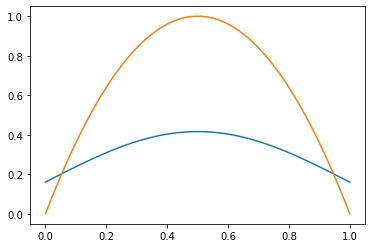

In [19]:
plt.plot(Xtest,u_next)
plt.plot(Xomega,u0)